## Set up of optimization problem: load libraries
We use the scipy.optimize library

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


## Define the parameters

In [8]:
c = 10                     # cost/ha of food production 
D = 10.0                    # food demand
alpha = 100000              # cost per unit of food shortage
a, b = 0.5, 1.5             # a and b represents lower and upper bound of the uniform distribution
p = 0.9                     # reliability level
np.random.seed(42)

# Generate yield samples
N = 10000                   # number of scenarios
Y_samples_uni = np.random.uniform(a, b, size=N)

## Define the objective function

In [10]:
def objective(x, Y_samples, c, D, alpha):
    x = x[0]  # unpack scalar from optimizer
    expected_penalty = alpha * np.mean(np.maximum(0, D - Y_samples * x))
    return c * x + expected_penalty

## TEST 1
For individual values of the penalty, find the optimal production. 

Questions: 
- What do you observe for different values of the penalty?
- Can you explain the intuition behind how the optimal solution changes as the penalty parameter varies?

Optimal x: 0.0000
Estimated expected cost: 50.0000


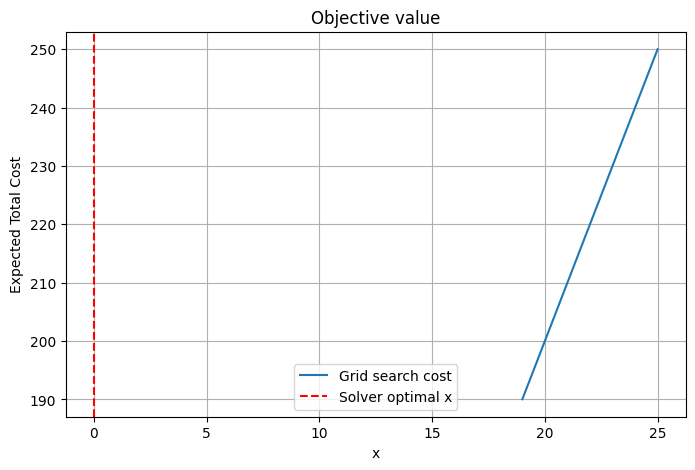

In [14]:
x0 = np.array([1.0])
# Constraint: x >= 0
bounds = [(0, None)]
alpha = 5
# Minimize the objective
res = minimize(
    objective,
    x0,
    args=(Y_samples_uni, c, D, alpha),
    bounds=bounds,
    method='L-BFGS-B'
)

# Output result
x_opt = res.x[0]
print(f"Optimal x: {x_opt:.4f}")
print(f"Estimated expected cost: {res.fun:.4f}")


x_grid = np.linspace(19, 25, 100)
costs = [objective([x], Y_samples_uni, c, D, alpha) for x in x_grid]

plt.figure(figsize=(8, 5))
plt.plot(x_grid, costs, label='Grid search cost')
plt.axvline(x_opt, color='red', linestyle='--', label='Solver optimal x')
plt.xlabel('x')
plt.ylabel('Expected Total Cost')
plt.title('Objective value')
plt.legend()
plt.grid(True)
plt.show()


## TEST 2
Plot the optimal solution as a function of the penalty

Questions: 
- What do you observe?
- What is the intuition?

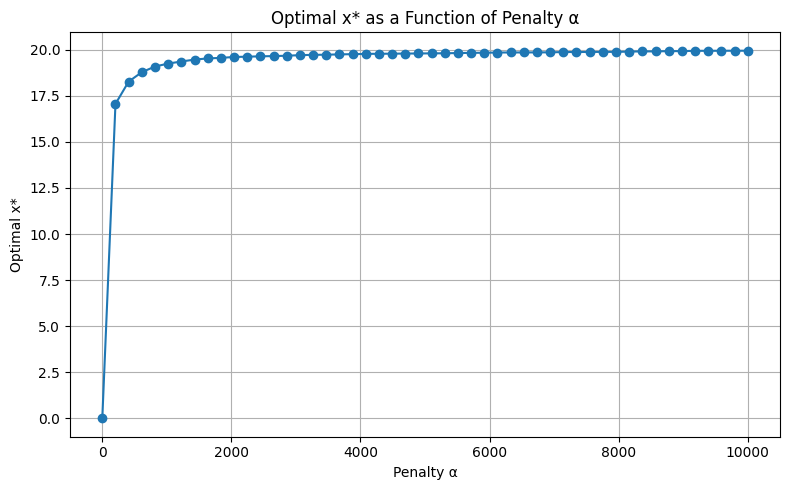

In [16]:
N_penalty = 50; 
alpha_values = np.linspace(0, 10000, N_penalty)
x_star_values_uni = np.zeros(N_penalty)

# Optimization loop
for ii in range(N_penalty):
    alpha = alpha_values[ii]
    res = minimize(
        objective,
        x0=[1.0],
        args=(Y_samples_uni, c, D, alpha),
        method='L-BFGS-B',
        bounds=[(0, None)]
    )
    x_star_values_uni[ii] = res.x[0]

# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, x_star_values_uni, marker='o')
plt.xlabel('Penalty α')
plt.ylabel('Optimal x*')
plt.title('Optimal x* as a Function of Penalty α')
plt.grid(True)
plt.tight_layout()
plt.show()


## TEST 3
Evaluate the food shortage probability

Questions:
- How can we find this probability?
- What can we conclude for uniformly distributed yields?

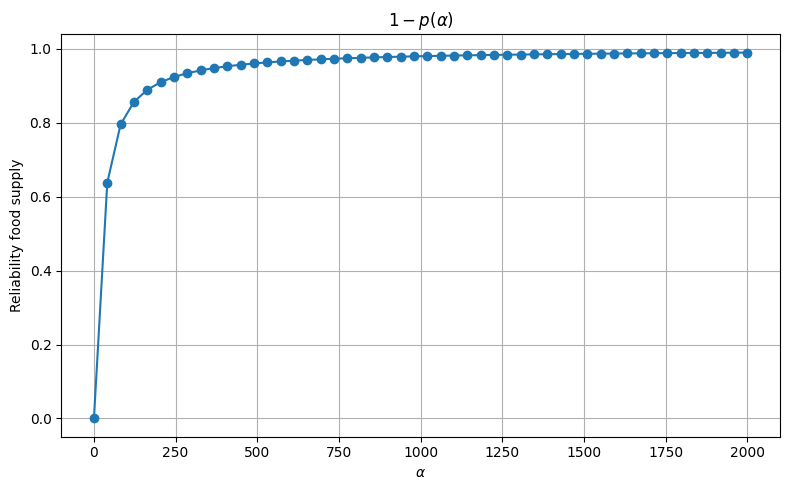

In [18]:
N_penalty = 50; 
alpha_values = np.linspace(0, 2000, N_penalty)
prob_noShortage_uni = np.zeros(N_penalty)

# Optimization loop
for ii in range(N_penalty):
    alpha = alpha_values[ii]
    res = minimize(
        objective,
        x0=[1.0],
        args=(Y_samples_uni, c, D, alpha),
        method='L-BFGS-B',
        bounds=[(0, None)]
    )
    prob_noShortage_uni[ii] =  np.sum(np.maximum(0, Y_samples_uni * res.x[0] - D) > 0)/N

# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(alpha_values,prob_noShortage_uni,marker='o')
plt.xlabel(r'$\alpha$')
plt.ylabel('Reliability food supply')
plt.title(r'$1-p(\alpha)$')
plt.grid(True)
plt.tight_layout()
plt.show()

## TEST 4
Consider now crop yields following a Normal distribution with same mean and standard deviation.

Questions
- What differences do we expect? 


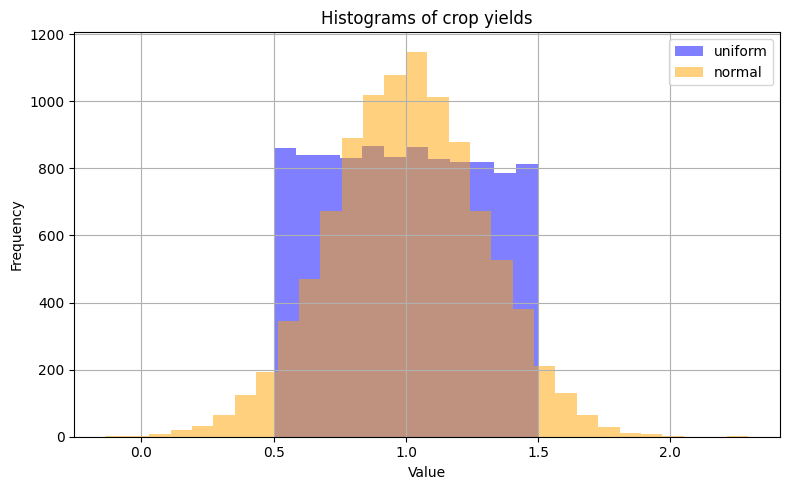

In [20]:
mean = (a + b)/2      
std_dev = (b-a)/np.sqrt(12)
Y_samples_normal = np.random.normal(loc = mean, scale = std_dev, size=N)

x_star_values_normal = np.zeros(N_penalty)
prob_noShortage_normal = np.zeros(N_penalty)

# plot histogram of both yield distributions
plt.figure(figsize=(8, 5))
plt.hist(Y_samples_uni, bins=12, alpha=0.5, label='uniform', color='blue')
plt.hist(Y_samples_normal, bins=30, alpha=0.5, label='normal', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of crop yields')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





Run the optimization and check if your intuitions were right. 

How can we explain the differences in reliability between the two distributions?

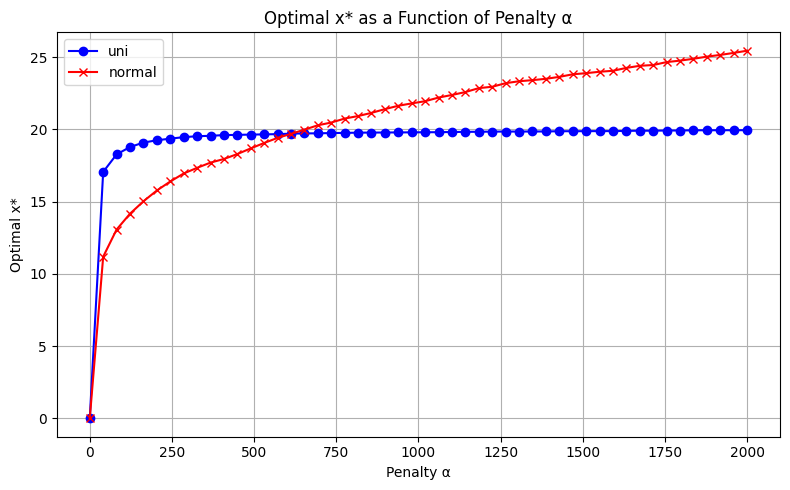

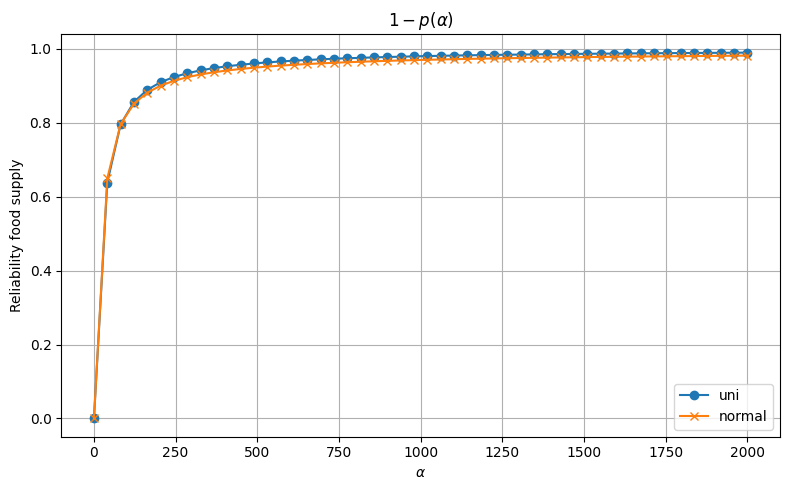

In [22]:
# optimization loop
for ii in range(N_penalty):
    alpha = alpha_values[ii]
    res = minimize(
        objective,
        x0=[1.0],
        args=(Y_samples_normal, c, D, alpha),
        method='L-BFGS-B',
        bounds=[(0, None)]
    )
    x_star_values_normal[ii] = res.x[0]
    prob_noShortage_normal[ii] =  np.sum(np.maximum(0, Y_samples_normal * res.x[0] - D) > 0)/N
    
# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, x_star_values_uni, label='uni', marker='o',color='blue')
plt.plot(alpha_values, x_star_values_normal, label='normal', marker='x', color='red')
plt.xlabel('Penalty α')
plt.ylabel('Optimal x*')
plt.title('Optimal x* as a Function of Penalty α')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(alpha_values,prob_noShortage_uni,label='uni',marker='o')
plt.plot(alpha_values,prob_noShortage_normal, label='normal', marker='x')
plt.xlabel(r'$\alpha$')
plt.ylabel('Reliability food supply')
plt.title(r'$1-p(\alpha)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## TEST 5
Numerical complexity: Compare different sample sizes with a validation set. 
1. Find optimal solution with lower sample size
2. Compare the expected penalties and check if the validation set gives a similar expected penalty

Questions: 
- What do you observe?
- What are the implications?

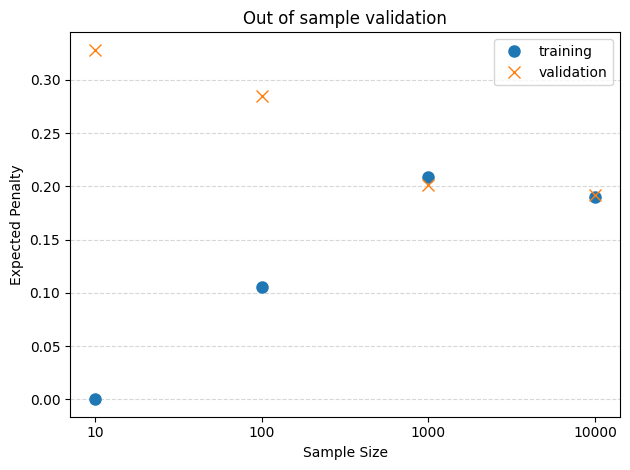

In [26]:
sampleSize = np.array([10, 100, 1000, 10000])
N_sampleSize = len(sampleSize)
    
x_star_values = np.zeros(N_sampleSize)
expPenalty_training = np.zeros(N_sampleSize)
expPenalty_validation = np.zeros(N_sampleSize)

N_validation = 100000
Y_samples_val = np.random.normal(loc = mean, scale = std_dev, size=N_validation) # validation set is >> selected sample sizes
# optimization loop
for ii in range(N_sampleSize):
    alpha = 250
    N_training = sampleSize[ii]
    Y_samples_training = np.random.normal(loc = mean, scale = std_dev, size=N_training)
    res = minimize(
        objective,
        x0=[1.0],
        args=(Y_samples_training, c, D, alpha),
        method='L-BFGS-B',
        bounds=[(0, None)]
    )
    x_star_values[ii] = res.x[0]
    expPenalty_training[ii] =  np.sum(np.maximum(0, D - Y_samples_training * res.x[0]))/N_training
    expPenalty_validation[ii] = np.sum(np.maximum(0, D - Y_samples_val * res.x[0]))/N_validation

# Plot the results
categories = ['10', '100', '1000', '10000']
x = range(len(categories))  # [0, 1, 2, 3]
# Plot
plt.plot(x, expPenalty_training, 'o', label='training', markersize=8)  # Circle marker
plt.plot(x, expPenalty_validation, 'x', label='validation', markersize=8)  # X marker

# Customize x-axis
plt.xticks(ticks=x, labels=categories)
plt.xlabel('Sample Size')
plt.ylabel('Expected Penalty')
plt.title('Out of sample validation')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## TEST 6
Value of Stochastic Solution (VSS)

Questions: 
- Describe what we observe?
- Is the VSS always meaningful?

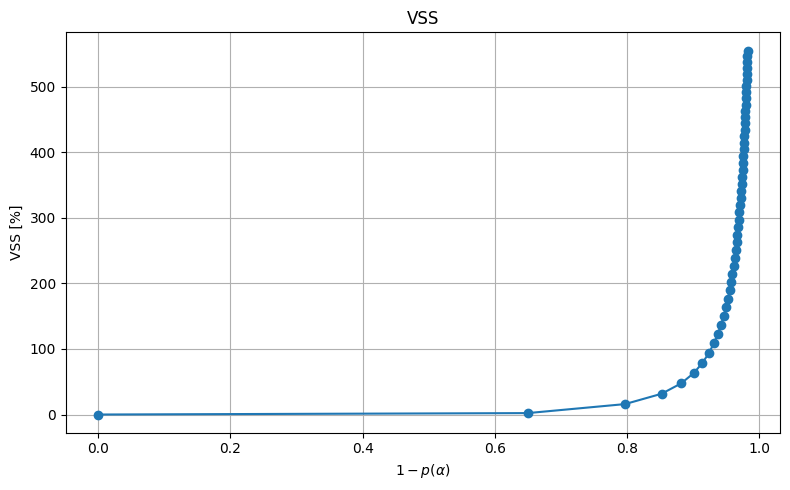

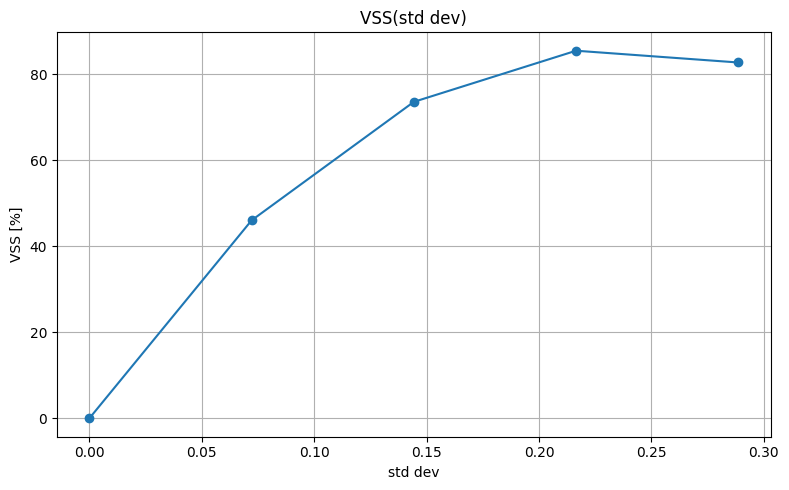

In [28]:
x_CE = D/mean
    
    
# Understand how the VSS behaves for different probabilistic constraints
N_penalty = 50; 
alpha_values = np.linspace(0, 2000, N_penalty)

expCost_CE = np.zeros(N_penalty)
expCost_RP = np.zeros(N_penalty)
VSS = np.zeros(N_penalty)

for ii in range(N_penalty):
    alpha = alpha_values[ii]
    res = minimize(
        objective,
        x0=[1.0],
        args=(Y_samples_normal, c, D, alpha),
        method='L-BFGS-B',
        bounds=[(0, None)]
    )
    expCost_CE[ii] = c * x_CE + alpha * np.mean(np.maximum(0, D - Y_samples_normal * x_CE))
    expCost_RP[ii] = res.fun
    #expCost_RP[ii] =  c * res.x[0] + alpha * np.mean(np.maximum(0, D - Y_samples_normal * res.x[0]))
    if expCost_RP[ii] > 0:
        VSS[ii] = 100 * (expCost_CE[ii] - expCost_RP[ii])/expCost_RP[ii]
    
# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(prob_noShortage_normal, VSS, marker='o')
plt.xlabel(r'$1-p(\alpha)$')
plt.ylabel('VSS [%]')
plt.title('VSS')
plt.grid(True)
plt.tight_layout()
plt.show()
    
# Understand how VSS behaves for different standard deviations
alpha = 250
steps_stddev = 5
std_dev_list = np.linspace(0, std_dev, steps_stddev)

expCost_CE_std = np.zeros(steps_stddev)
expCost_RP_std = np.zeros(steps_stddev)
VSS_std = np.zeros(steps_stddev)

for ii in range(steps_stddev):
    std_dev_VSS = std_dev_list[ii]
    Y_samples_VSS = np.random.normal(loc = mean, scale = std_dev_VSS, size=N)
    res = minimize(
        objective,
        x0=[1.0],
        args=(Y_samples_VSS, c, D, alpha),
        method='L-BFGS-B',
        bounds=[(0, None)]
    )
    expCost_CE[ii] = c * x_CE + alpha * np.mean(np.maximum(0, D - Y_samples_VSS * x_CE))
    expCost_RP[ii] = res.fun
    #expCost_RP[ii] =  c * res.x[0] + alpha * np.mean(np.maximum(0, D - Y_samples_normal * res.x[0]))
    if expCost_RP[ii] > 0:
        VSS_std[ii] = 100 * (expCost_CE[ii] - expCost_RP[ii])/expCost_RP[ii]

 
# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(std_dev_list, VSS_std, marker='o')
plt.xlabel('std dev')
plt.ylabel('VSS [%]')
plt.title('VSS(std dev)')
plt.grid(True)
plt.tight_layout()
plt.show()

## TEST 7
Expected Value of Perfect Information (EVPI)

Questions: 
- What do you observe?
- When does it become more interesting to invest in better data?

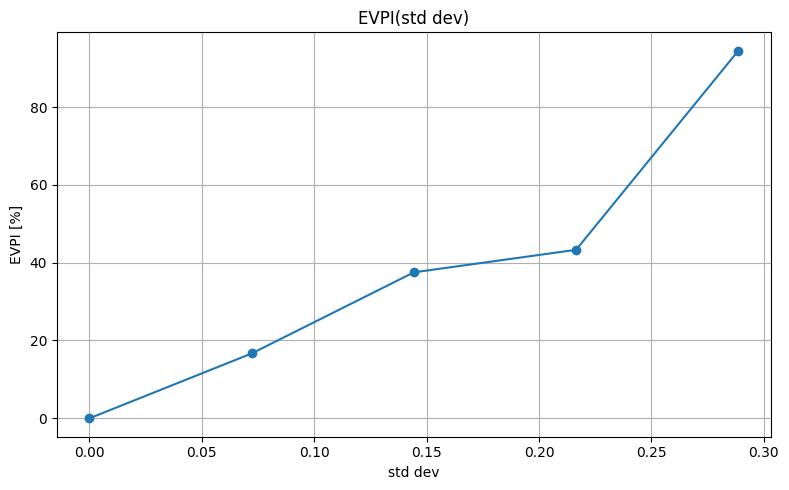

In [30]:
N = 100
    
expCost_RP = np.zeros(steps_stddev)
expCost_PI = np.zeros(steps_stddev)
EVPI_std = np.zeros(steps_stddev)

for ii in range(steps_stddev):
    std_dev_EVPI = std_dev_list[ii]
    Y_samples_EVPI = np.random.normal(loc = mean, scale = std_dev_EVPI, size=N)
    res = minimize(
        objective,
        x0=[1.0],
        args=(Y_samples_EVPI, c, D, alpha),
        method='L-BFGS-B',
        bounds=[(0, None)]
    )
    expCost_RP[ii] = res.fun
    
    x_PI = np.zeros(N)
    for jj in range(N):
        res = minimize(
            objective,
            x0=[1.0],
            args=(Y_samples_EVPI[jj], c, D, alpha),
            method='L-BFGS-B',
            bounds=[(0, None)]
            )
        x_PI[jj] = res.x[0]
    expCost_PI[ii] = np.mean(c*x_PI + np.maximum(0, D - Y_samples_EVPI * x_PI))
    
    
    #expCost_RP[ii] =  c * res.x[0] + alpha * np.mean(np.maximum(0, D - Y_samples_normal * res.x[0]))
    if expCost_PI[ii] > 0:
        EVPI_std[ii] = 100 * (expCost_RP[ii] - expCost_PI[ii])/expCost_PI[ii]
    
# Plotting results
plt.figure(figsize=(8, 5))
plt.plot(std_dev_list, EVPI_std, marker='o')
plt.xlabel('std dev')
plt.ylabel('EVPI [%]')
plt.title('EVPI(std dev)')
plt.grid(True)
plt.tight_layout()
plt.show()

## TEST 8
Multiple decision variables
Play around with the cost and stdev of both crops.

Questions: 
- What do we observe?
- In which ways is the complexity of the problem affected?

In [40]:
 # Parameters
c1, c2 = 15, 8             # Costs per unit for each crop
c = np.array([c1, c2])
alpha = 250                 # Penalty weight
D = 10                      # Demand
N = 1000                    # sample size

# Random yield samples for each crop (e.g., uniform or Gaussian)
np.random.seed(0)
Y1 = np.random.uniform(0.8, 1.2, N)
Y2 = np.random.uniform(0.5, 1.5, N)
    
# Combined sample matrix for convenience
Y_samples = np.column_stack((Y1, Y2))

# Objective function
def objective_vec(x, Y_samples, c, D, alpha):
    total_yield = np.dot(Y_samples, x)
    expected_penalty = alpha * np.mean(np.maximum(0, D - total_yield))
    return np.dot(c, x) + expected_penalty

# Initial guess and bounds
x0 = np.array([1.0, 1.0])
bounds = [(0, None), (0, None)]  # x1 ≥ 0, x2 ≥ 0


# Solve
res = minimize(
    objective_vec,
    x0,
    args=(Y_samples, c, D, alpha),
    bounds=bounds,
    method='L-BFGS-B'
)

# Results
x_opt = res.x
f_opt = res.fun
print(f"Optimal x: {x_opt}")
print(f"Minimum expected cost: {f_opt:.4f}")



Optimal x: [ 0.61627944 16.88442408]
Minimum expected cost: 151.8225
